In [1]:
import nltk
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

np.random.seed(42)
random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Саня\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Саня\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Саня\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Загрузка данных

In [2]:
data = pd.read_csv("Tweets.csv")
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
data.drop(columns=['textID', 'selected_text'], inplace=True)
data = data.dropna(axis=0).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27480 entries, 0 to 27479
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27480 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


## Разделение на тренировочную и тестовую выборку

In [4]:
y_factorized, uniques = pd.factorize(data['sentiment'], sort=True)
train_data, test_data = train_test_split(data, stratify=y_factorized, random_state=42)
uniques

Index(['negative', 'neutral', 'positive'], dtype='object')

## EDA
### Посмотрим на распределение классов. Присутствует незначительный дисбаланс

<Axes: >

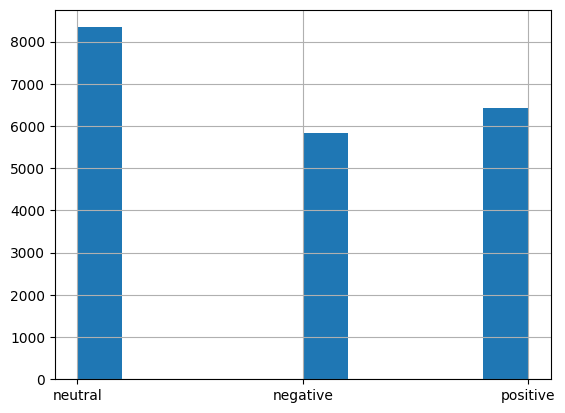

In [5]:
train_data['sentiment'].hist()

### Облако слов

Отобразим распределение самых часто встречающихся слов по классам. Не будем учитывать стоп слова и самые часто встречающиеся слова в датасете (чьё количество превышает 99.5 перцентиль)

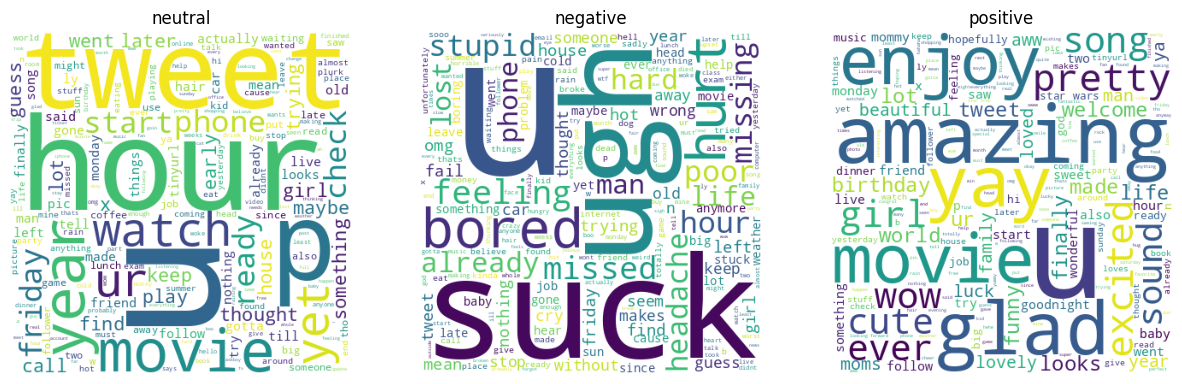

In [6]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

stop_words = stopwords.words('english')

vectorizer = CountVectorizer(stop_words=stop_words)
word_counts = np.asarray(vectorizer.fit_transform(train_data['text']).sum(0)).squeeze()

percentil_99 = np.percentile(word_counts, 99.5)
most_freq_inds = np.nonzero(word_counts > percentil_99)[0]

w2i_vocab = {v: k for k, v in vectorizer.vocabulary_.items()}

for ind in most_freq_inds:
    stop_words.append(w2i_vocab[ind])

stop_words = set(stop_words)
classes = train_data['sentiment'].unique()

fig, axes = plt.subplots(1, 3, figsize=(15, 15))
for i, cls in enumerate(classes):
    cls_data = train_data[train_data['sentiment'] == cls]['text']
    cls_str = ' '.join(cls_data.to_list()).lower()
    cloud = WordCloud(stopwords=stop_words, height=400, background_color='white').generate(cls_str)
    axes[i].imshow(cloud)
    axes[i].set_title(cls)
    axes[i].axis("off")
 
plt.show()

Как можно видеть, распределение самых частых слов отличается в зависимости от класса.

### Распределение по длине

Минимальная длина: 1. Максимальная длина: 106


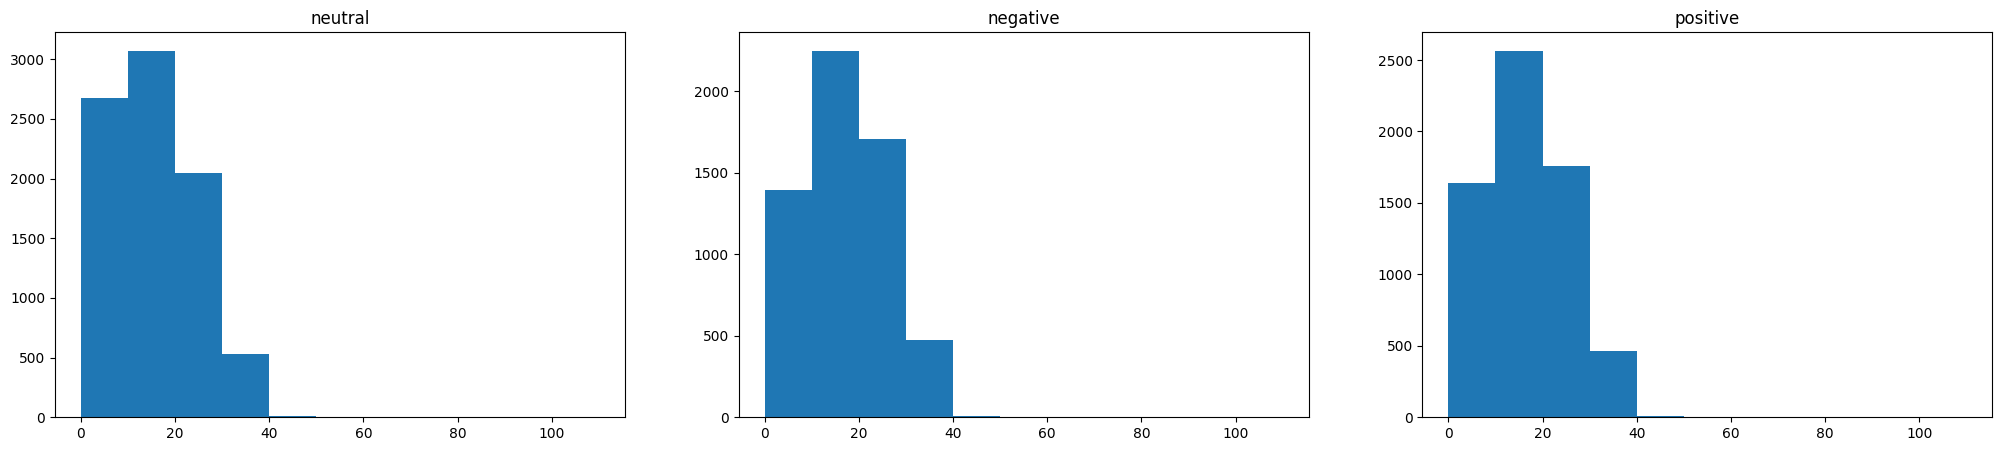

In [7]:
from nltk.tokenize import word_tokenize

text_lens = train_data['text'].apply(word_tokenize).apply(len)

print(f'Минимальная длина: {text_lens.min()}. Максимальная длина: {text_lens.max()}')

fig, axes = plt.subplots(1, 3, figsize=(25, 5))
bins = list(range(0, text_lens.max() + 10, 10))
for i, cls in enumerate(classes):
    cls_lens = text_lens[train_data['sentiment'] == cls]
    axes[i].hist(cls_lens, bins)
    axes[i].set_title(cls)

Распределение по длине почти не отличается между классами. У нейтрального класса больше коротких примеров

## Очистка данных

In [8]:
import re
from nltk.tokenize import word_tokenize
import pymorphy3

def clear_data(df, stopwords):
    morph = pymorphy3.MorphAnalyzer()
    df['text'] = df['text'].apply(lambda text: text.lower())
    df['text'] = df['text'].apply(lambda text: re.sub('[?!@#$1234567890#—ツ►๑۩۞۩•*”˜˜”)*°(°*``,.]', '', text))
    
    df['text'] = df['text'].apply(lambda text: word_tokenize(text))
    df['text'] = df['text'].apply(lambda text: [morph.parse(word)[0].normal_form for word in text if word not in stopwords])
    df['text'] = df['text'].apply(lambda text: ' '.join(text))
    return df

In [9]:
stop_words = stopwords.words('english')
train_data = clear_data(train_data, stop_words)
train_data.head()

,text,sentiment
13544,dm amigui,neutral
2889,got wheres sun =o,neutral
23822,im bored work,negative
22031,cant wait next twitter,positive
22970,tried sleep cant bout call tisha,negative


In [10]:
test_data = clear_data(test_data, stop_words)

## Классические ML алгоритмы
Возьмём 2 классических алгоритма машинного обучения - SVM для задачи классификации, а также RidgeRegression
В качестве методов векторизации выберем TF-IDF и Word2Vec размерности 300 обученный на Google news

### TF-IDF

In [19]:
def test_model(train_X, train_y, test_X, test_y, model):
    model.fit(train_X, train_y)
    preds = model.predict(test_X)
    print(classification_report(test_y, preds, target_names=uniques))

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report


vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,1))
train_X = vectorizer.fit_transform(train_data['text'])
train_y = pd.factorize(train_data['sentiment'], sort=True)[0]

test_X = vectorizer.transform(test_data['text'])
test_y = pd.factorize(test_data['sentiment'], sort=True)[0]

print('SVC model:')
classifier = SVC()
test_model(train_X, train_y, test_X, test_y, classifier)

print('RidgeRegression model:')
classifier = RidgeClassifier()
test_model(train_X, train_y, test_X, test_y, classifier)

SVC model:
              precision    recall  f1-score   support

    negative       0.76      0.56      0.64      1945
     neutral       0.61      0.80      0.69      2779
    positive       0.80      0.67      0.73      2146

    accuracy                           0.69      6870
   macro avg       0.72      0.67      0.69      6870
weighted avg       0.71      0.69      0.69      6870

RidgeRegression model:
              precision    recall  f1-score   support

    negative       0.68      0.61      0.65      1945
     neutral       0.62      0.70      0.66      2779
    positive       0.75      0.69      0.72      2146

    accuracy                           0.67      6870
   macro avg       0.68      0.67      0.68      6870
weighted avg       0.68      0.67      0.67      6870



## Word2Vec

In [13]:
import gensim
import gensim.downloader
from gensim.models import KeyedVectors
import tqdm

def docs_to_vectors(data: pd.DataFrame, vectorizer: KeyedVectors):
    text_data = data['text'].map(lambda text: text.split())
    all_vector_representation = []
    for document in tqdm.tqdm(text_data):
        doc_words = [word for word in document if word in vectorizer.key_to_index]
        if doc_words:
            vector_representation = sum([np.array(vectorizer[word]) for word in doc_words])
            vector_representation /= np.linalg.norm(vector_representation, ord=2)
        else:
            vector_representation = np.zeros(300,)
            
        all_vector_representation.append(vector_representation)

    all_vector_representation = np.stack(all_vector_representation, axis=0)
    print(all_vector_representation.shape)

    return all_vector_representation

In [14]:
vector_type = 'word2vec-google-news-300'
vectors_vocab = gensim.downloader.load(vector_type)

In [15]:
vectorized_data_train = docs_to_vectors(train_data, vectors_vocab)
vectorized_data_test = docs_to_vectors(test_data, vectors_vocab)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20610/20610 [00:00<00:00, 37953.64it/s]


(20610, 300)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6870/6870 [00:00<00:00, 35590.12it/s]

(6870, 300)


In [22]:
print('SVC model:')
classifier = SVC()
test_model(vectorized_data_train, train_y, vectorized_data_test, test_y, classifier)

print('RidgeRegression model:')
classifier = RidgeClassifier()
test_model(vectorized_data_train, train_y, vectorized_data_test, test_y, classifier)

SVC model:
              precision    recall  f1-score   support

    negative       0.72      0.65      0.68      1945
     neutral       0.65      0.74      0.69      2779
    positive       0.77      0.70      0.73      2146

    accuracy                           0.70      6870
   macro avg       0.71      0.69      0.70      6870
weighted avg       0.71      0.70      0.70      6870

RidgeRegression model:
              precision    recall  f1-score   support

    negative       0.70      0.64      0.67      1945
     neutral       0.64      0.72      0.68      2779
    positive       0.74      0.69      0.71      2146

    accuracy                           0.69      6870
   macro avg       0.70      0.68      0.69      6870
weighted avg       0.69      0.69      0.69      6870



In [18]:
np.save('w2v_300_train.npy', vectorized_data_train)
np.save('w2v_300_test.npy', vectorized_data_test)